# Introduction
> This book is part of a detailed writeup on analyzing the [CORD 19 Research Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) dataset . Please [visit this link](https://www.kaggle.com/finalepoch/cord-19-research-dataset-analysis-visualization) for the main page which contains more information and context.

In this notebook I have tried to create a Named Entity Recognition system for analyzing the [CORD 19 Research Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) dataset. I am tyring to use Spacy's [custom named entity recognition](https://spacy.io/usage/training/) to train a model that can detect mentions of three things in text:
* MedicalCondition
* Medicine
* Pathogen

I have currently used [LightTag](https://www.lighttag.io/) for creating a manually tagged corpus from randomly selected text from Wikipedia. The dataset is available here : [https://www.kaggle.com/finalepoch/medical-ner](https://www.kaggle.com/finalepoch/medical-ner)


## Load the annotated corpus

In [1]:
import json
with open("/kaggle/input/medical-ner/Corona2.json") as f:
    annotation = json.load(f)

Convert the tagged data to a format understood by Spacy. Remove anything that has spaces and does **not** have   *"human_annotations"* . LightTag gui has bugs which give overlapping entites that results in error during training

In [2]:
TRAIN_DATA  = []
for e in annotation["examples"]:
    content = e["content"]
    entities = []
    for an in e["annotations"]:        
        if len(an["value"]) == len(an["value"].strip()):          
            if len(an['human_annotations']) == 0:
                continue
            info = (an["start"],an["end"],an["tag_name"])
            entities.append(info)
            #print(an["start"],an["end"],an["tag_name"])
    if len(entities) > 0:
        TRAIN_DATA.append(([content,{"entities":entities}]))    

## Train Spacy model
I am currently using a blank spacy model. I have tried using 'en_core_web_sm' and 'en_core_web_lg', but it doesnt result in any dramatic improvement. 

> There is a lot of scope for experimenting here. When I get time, I will try out more things !

In [3]:
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
from spacy.util import minibatch, compounding
import spacy
import sys

In [4]:
spacy.util.use_gpu(0)
def train_model(model=None, output_dir="/kaggle/working/medical-ner", n_iter=1000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            nlp.begin_training(device=0)
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 64.0, 1.2))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  
                    annotations,  
                    drop=0.20, 
                    losses=losses
                   
                )
            print("Losses", losses)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [5]:
train_model()

Created blank 'en' model
Losses {'ner': 3046.4351801872253}
Losses {'ner': 625.0396368786714}
Losses {'ner': 554.8546083738674}
Losses {'ner': 548.4857454486191}
Losses {'ner': 434.0557030525524}
Losses {'ner': 437.50986689538695}
Losses {'ner': 361.7001786280016}
Losses {'ner': 326.42289236880606}
Losses {'ner': 292.18727480788766}
Losses {'ner': 249.33850929067455}
Losses {'ner': 266.2187453772611}
Losses {'ner': 351.0062587892746}
Losses {'ner': 371.0330508232917}
Losses {'ner': 313.39293594633716}
Losses {'ner': 241.08785659475006}
Losses {'ner': 277.9553204744466}
Losses {'ner': 238.57528326012107}
Losses {'ner': 198.82854716640347}
Losses {'ner': 167.6301625615094}
Losses {'ner': 163.7992651974648}
Losses {'ner': 131.69805740511387}
Losses {'ner': 120.61799679307936}
Losses {'ner': 111.99113950191648}
Losses {'ner': 135.7068747427054}
Losses {'ner': 101.39442078697357}
Losses {'ner': 104.47095146558814}
Losses {'ner': 85.60406783014844}
Losses {'ner': 56.63258208859364}
Losses {'

## Make predections on CORD-19-research-challenge dataset

In [6]:
nlp2 = spacy.load("/kaggle/working/medical-ner")

In [7]:
import numpy as np
import pandas as pd
import os
import json
import random

files = []
for dirname, _, filenames in os.walk('/kaggle/input/CORD-19-research-challenge/'):
    for filename in filenames:
        if ".json" in filename:           
            fpath = os.path.join(dirname, filename)
            if len(files) < 300:
                files.append(fpath)
random.shuffle(files)

In [8]:
output = []
entities = []
for i in range(0,len(files)):
    if i%100 == 0:
        print('completed ', i)
    with open(files[i]) as f:
        file_data = json.load(f)        
    for o in file_data["body_text"]: 
            doc = nlp2(o["text"],disable=['parser','tagger'])
            for ent in doc.ents:
                if len(ent.text) > 2:
                    entities.append((ent.text, ent.label_))

completed  0
completed  100
completed  200


## Plot the results on sample dataset (where count > n)

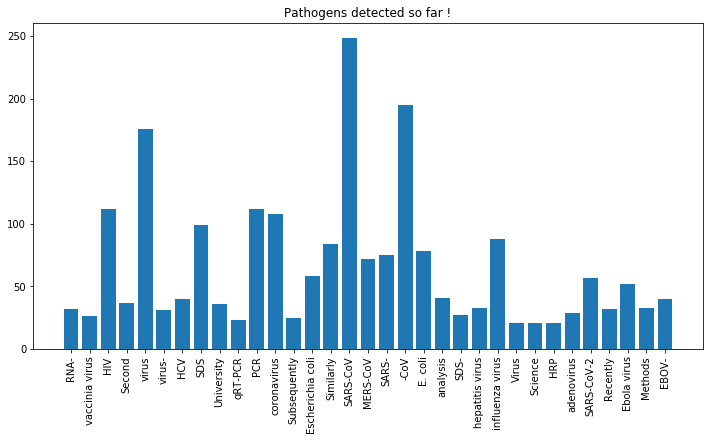

<Figure size 864x432 with 0 Axes>

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
pathogens = [l[0] for l in entities if l[1] == 'Pathogen']
counts = Counter(pathogens)
counts = {x : counts[x] for x in counts if counts[x] >= 20}
plt.title("Pathogens detected so far !")
plt.xticks(rotation='vertical')
plt.bar(counts.keys(),counts.values())
plt.show()
plt.savefig('path.png')

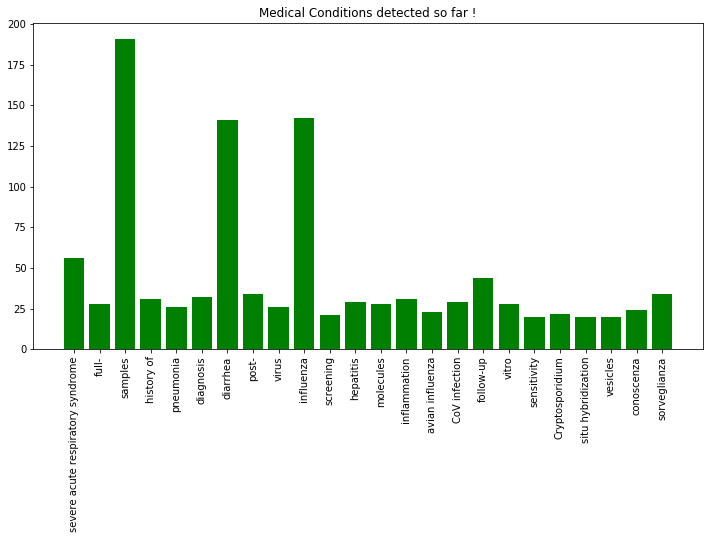

<Figure size 864x432 with 0 Axes>

In [10]:
medical_conds = [l[0] for l in entities if l[1] == 'MedicalCondition']
counts = Counter(medical_conds)
counts = {x : counts[x] for x in counts if counts[x] >=20 and len(x) > 4}
plt.xticks(rotation='vertical')
plt.title("Medical Conditions detected so far !")
plt.bar(counts.keys(),counts.values(),color ="g")
plt.show()
plt.savefig('mc.png')

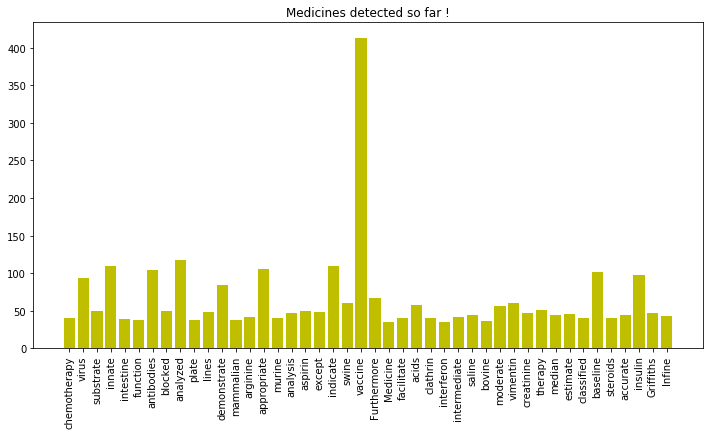

<Figure size 864x432 with 0 Axes>

In [11]:
medicines = [l[0] for l in entities if l[1] == 'Medicine']
counts = Counter(medicines)
counts = {x : counts[x] for x in counts if counts[x] >=35 and len(x) > 4}
#plt.xticks(counts.keys(),rotation='vertical')
plt.xticks(rotation='vertical')
plt.title("Medicines detected so far !")
plt.bar(counts.keys(),counts.values(),color="y")
plt.show()
plt.savefig('med.png')

# Things to improve upon

* An accurate NER tagger is key to my approach. However, it is difficult to create a manually tagged corpus single handedly. Need to collobrate on this with community !

* Create a scheme to augument the manually labelled data and expand training data

* Spacy does not give any 'confidence' measure along with NER tagging. This makes it impossible to apply a threshould and filter out unimportant or wrongly identified entities. Maybe using some library as a base may help !

* Implement mechanisms to check the accuracy of NER tagging after training. Currently it does work, but not sure how well !